# Finding and Graphing Temperature Extrema

## Assignment Details

An NOAA dataset has been stored in a csv file. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

In [2]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

In [3]:
def get_source_data():
    filename = 'data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv'
    df = pd.read_csv(filename)
    
    #CLEANUP
    #Convert to degrees celcius
    df['Data_Value'] = df['Data_Value'] * 0.1
    
    #Convert dates to datetime type
    df['Date'] = pd.to_datetime(df['Date'])
    #Remove Feb 29
    df = df[df['Date'].dt.strftime('%m-%d') != '02-29']
    #Add Day Column
    df['Day'] = df['Date'].dt.strftime('%m-%d')
    
    return df

get_source_data().head()

,ID,Date,Element,Data_Value,Day
0,USW00094889,2014-11-12,TMAX,2.2,11-12
1,USC00208972,2009-04-29,TMIN,5.6,04-29
2,USC00200032,2008-05-26,TMAX,27.8,05-26
3,USC00205563,2005-11-11,TMAX,13.9,11-11
4,USC00200230,2014-02-27,TMAX,-10.6,02-27


In [4]:
def group_range_data(df):
    df_range = df[(df['Date'].dt.year >= 2005) & (df['Date'].dt.year <= 2014)]
    df_max = df_range[df_range['Element'] == 'TMAX']
    df_min = df_range[df_range['Element'] == 'TMIN']
    
    day = df_range['Date'].dt.strftime('%m-%d')
    
    sMax = df_max.groupby(day)['Data_Value'].max()
    sMin = df_min.groupby(day)['Data_Value'].min()

    df_result = pd.DataFrame({'Min': sMin, 'Max': sMax})
    df_result.reset_index(drop=False, inplace=True)
    df_result.rename(inplace=True, columns={'Date' : 'Day'})
    
    return df_result

group_range_data(get_source_data()).head()

,Day,Max,Min
0,01-01,15.6,-16.0
1,01-02,13.9,-26.7
2,01-03,13.3,-26.7
3,01-04,10.6,-26.1
4,01-05,12.8,-15.0


In [5]:
def get_record_data(df):
    df = df[df['Date'].dt.year == 2015]
    
    highs = df[df['Data_Value'] > df['Max']]
    lows = df[df['Data_Value'] < df['Min']]
    
    print(highs.head())
    
    return highs, lows

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib notebook
%matplotlib inline

import numpy as np

In [7]:
def main_plot(df, hi, low):  
    scatter = {
        's' : 20,
        'a' : 0.5,
    }
    
    line = {
        'w' : 1,
        'a' : 0.3,
    }
    fill = {
        'a' : 0.2,
    }
    colors = {
        #lines
        'lmax' : 'grey',
        'lmin' : 'grey',
        #dots
        'rmax' : 'red',
        'rmin' : 'green',
        #fill
        'fill' : 'grey',
    }
    
    date_range = np.arange('2015-01-01','2016-01-01', dtype='datetime64[D]')
    
    fig = plt.figure(figsize=(12, 8))
    plt.plot(date_range, df['Min'], alpha=line['a'], linewidth=line['w'], color=colors['lmin'], label = 'Record Low [\'05-\'14]')
    plt.plot(date_range, df['Max'], alpha=line['a'], linewidth=line['w'], color=colors['lmax'], label = 'Record High [\'05-\'14]')
    
    plt.scatter(low['Date'].values, low['Data_Value'].values, s=scatter['s'], alpha=scatter['a'], color=colors['rmin'], label = 'Record Breaking Low (\'15)')
    plt.scatter(hi['Date'].values, hi['Data_Value'].values, s=scatter['s'], alpha=scatter['a'], color=colors['rmax'], label = 'Record Breaking High (\'15)')

    ax = plt.gca()
    #fill gray area between min and max
    ax.fill_between(date_range, df['Min'], df['Max'], alpha=fill['a'], facecolor=colors['fill'])
    
    #x/y limits
    ax.axis(['2015/01/01','2015/12/31', -50, 50]) #axis limits
    plt.ylim(-40,50)
    
    #TITLES AND LABELS ########
    
    #where and how to place xticks
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    
    #Format font of x/y ticks
    for axis in ax.xaxis, ax.yaxis:
        for tick in axis.get_major_ticks():
                    tick.label.set_fontsize(12) 
    
    plt.legend(loc=8, fontsize='x-large', frameon=True, markerscale=1.5, framealpha=1)
    
    plt.grid(True, axis='y', color='#A0522D', alpha=0.6)
    
    #Axis Labels
    plt.xlabel('Day {only Month is shown}', fontsize='x-large')
    plt.ylabel('Temperature (degrees Celcius)', fontsize='x-large')
    
    location = 'Ann Arbor, Michigan, United States'
    plt.title('Record temperatures between [2005-2014] overlayed by record breaking temperatures in 2015 \n Measured near ' + location, fontsize='x-large')
    
    fig.savefig('assignment2.png', transparent=False)
    
    

               ID       Date Element  Data_Value    Day   Max   Min
3682  USW00014833 2015-12-14    TMAX        15.6  12-14  13.9 -16.1
3689  USW00014853 2015-12-14    TMAX        17.2  12-14  13.9 -16.1
3693  USC00207312 2015-12-14    TMAX        16.7  12-14  13.9 -16.1
3695  USC00202308 2015-12-14    TMAX        17.2  12-14  13.9 -16.1
3696  USC00202308 2015-12-14    TMIN        14.4  12-14  13.9 -16.1


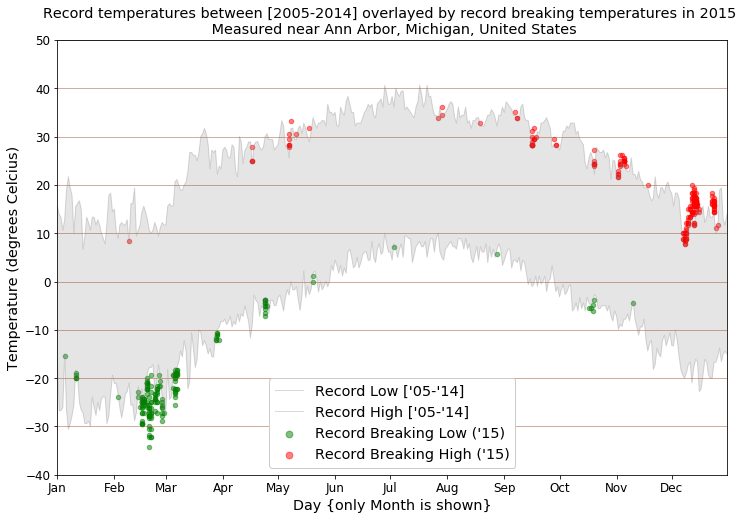

In [8]:
def main():
    df = get_source_data()
    
    df_days = group_range_data(df)

    df = df.merge(df_days)
    
    hi15, lo15 = get_record_data(df)
    
    main_plot(df_days, hi15, lo15)
    

main()